In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay , ConvexHull
import matplotlib as mpl
from matplotlib.colors import ListedColormap ,LinearSegmentedColormap, to_rgba
import scipy.spatial as sc
import matplotlib.patches as patches
import copy
import os
from matplotlib.collections import PolyCollection

%xmode Plain

def pnt_in_cvex_hull(hull,pnt): 
    '''checks if 'pnt' is inside the convex hull'''
    new_hull = ConvexHull(np.concatenate((hull.points, [pnt])))
    if np.array_equal(new_hull.vertices, hull.vertices):
        return True
    else:
        return False 

    
    
def height(p,vertices,seeds,altitudes):
    max_dist=0
    '''
    finding the shortest edge
    '''
    for i in range(3):
        for j in range(i+1,4):
            dist = np.linalg.norm(vertices[i]-vertices[j])
            if dist > max_dist:
                max_dist = dist
                furthest = np.array([i,j])

    '''
    reordering everything
    '''
    vertices[[0,furthest[0]]] = vertices[[furthest[0],0]]
    vertices[[1,furthest[1]]] = vertices[[furthest[1],1]]

    seeds[[0,furthest[0]]] = seeds[[furthest[0],0]]
    seeds[[1,furthest[1]]] = seeds[[furthest[1],1]]

    altitudes[[0,furthest[0]]] = altitudes[[furthest[0],0]]
    altitudes[[1,furthest[1]]] = altitudes[[furthest[1],1]]

    '''
    creating new edge
    newaltitude = average altitude + random(-0,05;0,05)*sqrt(
    distance)
    '''
    v_new = (vertices[0]+vertices[1])/2
    s_new = (seeds[0]+seeds[1])/2
    random.seed(s_new)
    a_new = (altitudes[0]+altitudes[1])/2+0.01*(random.random()
    -0.5)*max_dist**1.5

    '''
    finding in which tetrahedon the point p is
    '''
    tetra = np.copy(vertices)
    tetra[1] = v_new
    hull = ConvexHull(tetra)

    if pnt_in_cvex_hull(hull,p):
        vertices[1] = v_new
        seeds[1] = s_new
        altitudes[1] = a_new
    else:
        vertices[0] = v_new
        seeds[0] = s_new
        altitudes[0] = a_new

    '''
    stop if resolution is great enough
    '''
    if max_dist <= 0.001:
        return np.sum(altitudes)/4
    else:
        height(p,vertices,seeds,altitudes)
    return np.sum(altitudes)/4

def sph_to_cart(phi,theta): #for r = 1
    return np.array([np.cos(phi)*np.sin(theta),np.sin(phi)*np.sin(theta),np.cos(theta)])

def cart_to_sph(x,y,z):
    return np.array([np.arctan2(y,x),np.arctan2(np.sqrt(x**2+y**2),z)])

Exception reporting mode: Plain


In [2]:
'''
initialize sphere and final altitudes vector
'''
numpoints = 1001
plot_facets_vor = np.load('plot_facets_n'+str(numpoints)+'.npy',allow_pickle=',')
voronoi_grid = np.loadtxt('voronoi_grid_n'+str(numpoints),delimiter=',') #phi, theta, area
phi, theta, area = voronoi_grid[:,0], voronoi_grid[:,1], voronoi_grid[:,2]
x = np.cos(phi)*np.sin(theta)
y = np.sin(phi)*np.sin(theta)
z = np.cos(theta)
sphere = np.stack((x, y, z),axis=1)

albedo_map = np.zeros((len(sphere[:,0])))
albedo_colors = np.zeros((len(sphere[:,0]),4))

In [3]:
%%time
seeds = np.array([[8.3e5, 2.5e5, 3.65e5, 7.4e5],[1,4,6,7],[4e3,3e5,6e2,5e3],[6e7,4e5,5e5,3e6],[5,2,5,6],[12354,432134,23453245,24512],[1,2342345523,2,3],[2,2342345520,2,3]])
seed_no = 0


filename = 'alts/alts_'+ str(seed_no) +'n'+str(numpoints)+'.txt'
if os.path.exists(filename):
    alts = np.loadtxt(filename,delimiter=',')
else:
    '''
    calculate altitude for every point on sphere
    '''
    alts = np.zeros(len(sphere[:,0]))
    for i in range(len(sphere[:,0])):
        vertices_ = np.array([[-2,2.1,2.2],[2,-2.1,2.2],[2,2.1,-2.2],[-2.3,-2.4,-2.5]])

        seeds_,altitudes_ = copy.copy(seeds[seed_no]),np.array([0.,0.,0.,0.])
        point = sphere[i,:]
        alt = height(point,vertices_,seeds_,altitudes_)
        alts[i] = alt
    os.makedirs(os.path.dirname(filename),exist_ok = True)
    np.savetxt(filename,alts,delimiter=',')

Wall time: 4.95 ms


In [4]:
'''
calculate albedomap
'''
alts = alts-np.mean(alts)
max_alt = np.amax(alts)
min_alt = np.amin(alts)
norm_alts = (alts-min_alt)/(max_alt-min_alt)

snowheight = 0.8
soilheight = 0.4

gist_earth = mpl.cm.get_cmap('gist_earth',4000) #colors
N = 256
y1 = gist_earth(np.linspace(0.02,0.15,int(N/2))) #ocean colors, for half the heights
y2 = gist_earth(np.linspace(0.3,0.5,int(N/2*soilheight))) #forest colors
y3 = gist_earth(np.linspace(0.76,0.85,int(N/2*(snowheight-soilheight)))) #soil colors
y4 = gist_earth(np.linspace(0.93,1,int(N/2*(1-snowheight)))) #snow colors

y = np.vstack((y1,y2,y3,y4))
cmap = LinearSegmentedColormap.from_list('custom earth', y, N=256)

albedos = np.array([0.06,0.15,0.4,0.8]) # albedos of water, vegetation, sand desert and snow in lambertian reflection, lomsee and water reflection
for i in range(len(sphere[:,0])):
    if alts[i] >= snowheight*max_alt:
        albedo_map[i] = albedos[3] #snow
        albedo_colors[i] = to_rgba('white')
    elif alts[i] < 0.0:
        albedo_map[i] = albedos[0] #ocean
        albedo_colors[i] = gist_earth(0.05)
    elif (alts[i] >= soilheight*max_alt and alts[i]<snowheight*max_alt):
        albedo_map[i] = albedos[2] #soil
        albedo_colors[i] = gist_earth(0.8)
    elif (alts[i] >= 0.0 and alts[i]<soilheight*max_alt):
        albedo_map[i] = albedos[1] #forest
        albedo_colors[i] = gist_earth(0.4)
filename = 'albedos/albedo_map'+ str(seed_no) +'_n' + str(numpoints) +'.txt'
os.makedirs(os.path.dirname(filename), exist_ok=True)
np.savetxt(filename,albedo_map,delimiter=',')

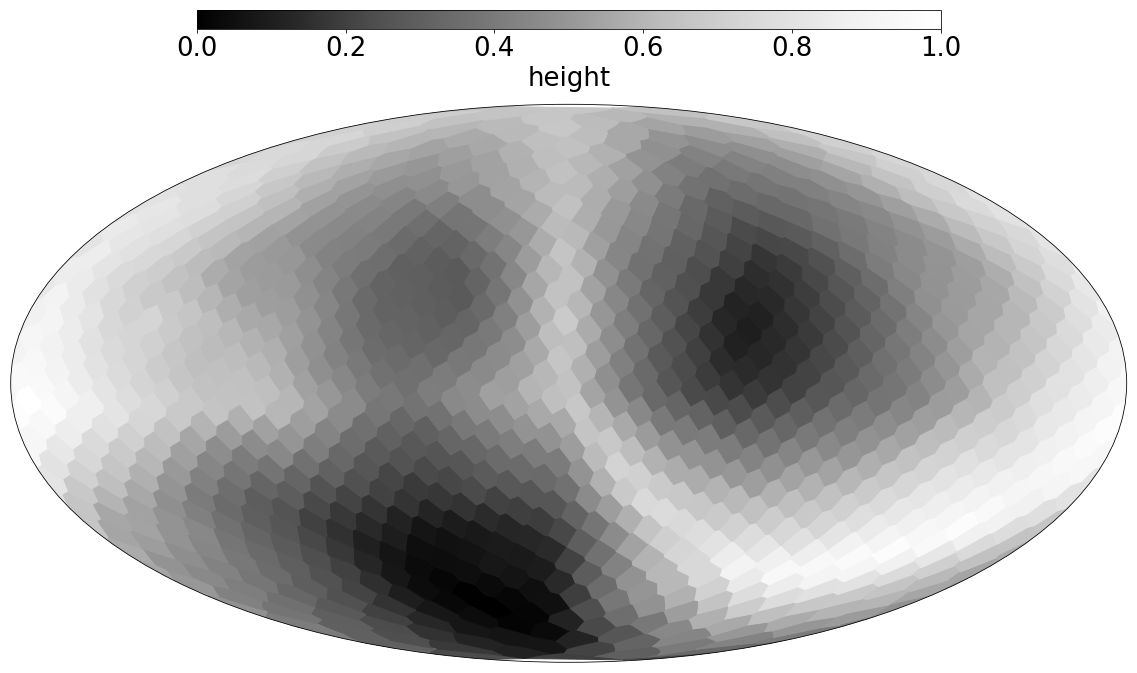

Wall time: 3.84 s


In [5]:
%%time
# Mollweide plot of the heights
mpl.rcParams.update({'font.size': 26})

fig = plt.figure(figsize = [20,20])
ax = fig.add_subplot(111,projection='mollweide')

cmap = mpl.cm.get_cmap('Greys_r',4000)
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = cmap)
cmapplot.set_array([])
cb = fig.colorbar(cmapplot, ax=ax, orientation='horizontal', label='height',shrink=1/1.5, aspect=40,pad=-0.6)


# plot the facets
ax.add_collection(PolyCollection(plot_facets_vor,array=norm_alts,cmap=cmap,edgecolor='face')) #plot majority of facets
i=0
for facet_sph in plot_facets_vor: #deal with the facets over the edges by plotting them again with phi+-2pi
    c = cmap(norm_alts[i])
    if np.any(facet_sph[:,0]>np.pi):
        ax.add_patch(patches.Polygon(np.stack((facet_sph[:,0]-2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
    elif np.any(facet_sph[:,0]<-np.pi):
        ax.add_patch(patches.Polygon(np.stack((facet_sph[:,0]+2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
    i+=1
    
ax.set_xticklabels([])
ax.set_yticklabels([])
filename = 'heightplots/heights_seed'+ str(seed_no) +'n'+str(numpoints)+'.png'
os.makedirs(os.path.dirname(filename), exist_ok=True)
plt.savefig(filename,dpi=100, bbox_inches='tight')
plt.show()


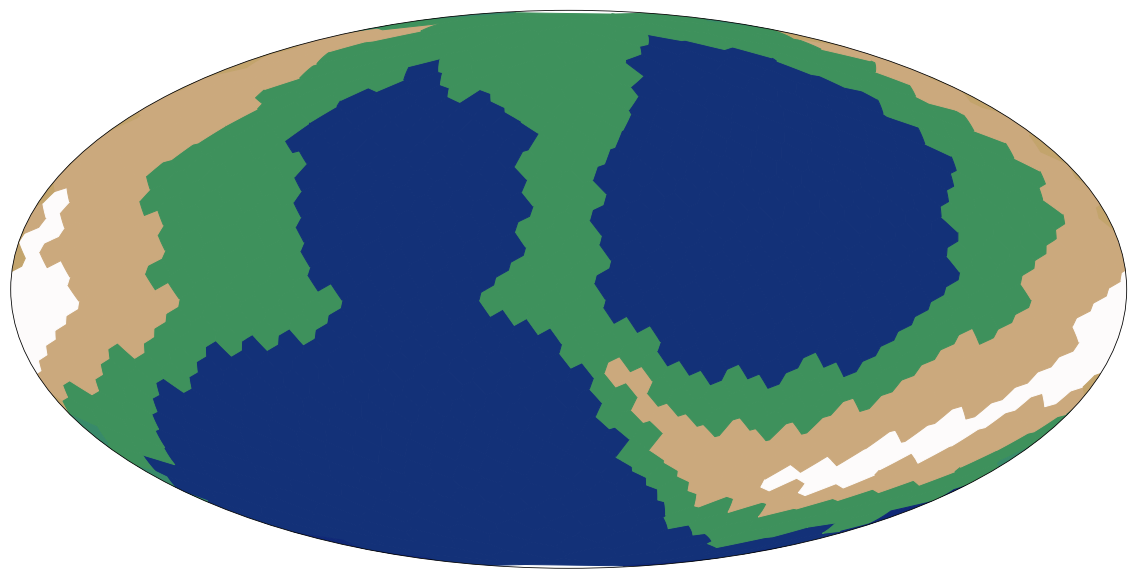

Wall time: 3.87 s


In [6]:
%%time
snowheight = 0.8
soilheight = 0.4

N=256

y1 = gist_earth(np.linspace(0.02,0.15,int(N*(albedos[1]+albedos[0])))) #ocean colors, for half the heights
y2 = gist_earth(np.linspace(0.3,0.5,int(N*(albedos[2]-albedos[0])))) #forest colors
y3 = gist_earth(np.linspace(0.76,0.85,int(N*(albedos[3]-albedos[1])))) #soil colors
y4 = gist_earth(np.linspace(0.93,1,int(N*(0.8-albedos[2])))) #snow colors
y = np.vstack((y1,y2,y3,y4))

cmap_albedo = LinearSegmentedColormap.from_list('custom earth', y, N=256)

mpl.rcParams.update({'font.size': 26})

fig = plt.figure(figsize = [20,20])
# ax = fig.add_subplot(211)
ax = fig.add_subplot(111,projection='mollweide')


norm = mpl.colors.Normalize(vmin=0, vmax=0.8)
cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = cmap_albedo)
cmapplot.set_array([])
# cb = fig.colorbar(cmapplot, ax=ax, orientation='horizontal', label='albedo',shrink=1/1.5,aspect=40,pad=-.6)

#plot the facets

ax.add_collection(PolyCollection(plot_facets_vor,array= albedo_map/0.8,cmap=cmap_albedo,edgecolor='face',norm=norm)) #plot majority of facets
i=0
for facet_sph in plot_facets_vor: #deal with the facets over the edges by plotting them again with phi+-2pi
    c = cmap_albedo(albedo_map[i]/0.8)
    if np.any(facet_sph[:,0]>np.pi):
        ax.add_patch(patches.Polygon(np.stack((facet_sph[:,0]-2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
    elif np.any(facet_sph[:,0]<-np.pi):
        ax.add_patch(patches.Polygon(np.stack((facet_sph[:,0]+2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
    i+=1

ax.set_xticklabels([])
ax.set_yticklabels([])


filename = 'albedos/albedo_seed'+ str(seed_no) +'n' + str(numpoints) + '.png'
os.makedirs(os.path.dirname(filename), exist_ok=True)
plt.savefig(filename,bbox_inches='tight',dpi=100)
plt.show()

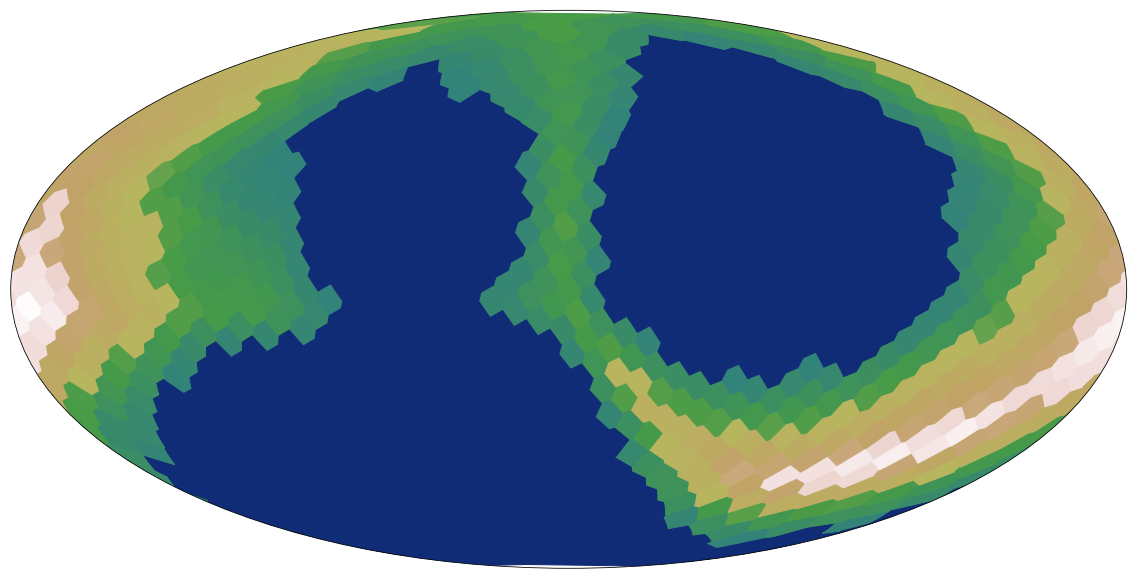

In [7]:
snowheight = 0.8
soilheight = 0.4
waterheight = 0
albedo_map_r = np.zeros(numpoints)
for i in range(numpoints):
    if alts[i] >= snowheight*max_alt:#snow
        albedo_map_r[i] = 0.6+(alts[i]-snowheight*max_alt)/(max_alt-snowheight*max_alt)*0.3
    elif alts[i] < 0.0: #water
        albedo_map_r[i] = 0.06
    elif (alts[i] >= soilheight*max_alt and alts[i]<snowheight*max_alt): #soil
        albedo_map_r[i] = 0.3+(alts[i]-soilheight*max_alt)/(snowheight*max_alt-soilheight*max_alt)*0.2
    elif (alts[i] >= waterheight*max_alt and alts[i]<soilheight*max_alt): #forest
        albedo_map_r[i] = 0.1+(alts[i]-waterheight*max_alt)/(soilheight*max_alt-waterheight*max_alt)*0.2 
        
gist_earth = mpl.cm.get_cmap('gist_earth',4000) #colors
N = 256
y1 = gist_earth(np.linspace(0.02,0.15,int(N*0.1))) #ocean colors
y2 = gist_earth(np.linspace(0.3,0.5,int(N*0.2))) #forest colors
y3 = gist_earth(np.linspace(0.7,0.85,int(N*0.25))) #soil colors
y4 = gist_earth(np.linspace(0.93,1,int(N*.35))) #snow colors
y = np.vstack((y1,y2,y3,y4))

cmap_albedo = LinearSegmentedColormap.from_list('custom earth', y, N=256)

fig = plt.figure(figsize = [20,20])
ax = fig.add_subplot(111,projection='mollweide')
norm = mpl.colors.Normalize(vmin=0,vmax=0.9)
cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = cmap_albedo)
cmapplot.set_array([])
# cb = fig.colorbar(cmapplot, ax=ax, orientation='horizontal',shrink=1/1.5, aspect=40,pad=-0.6)
# cb.set_label('Albedo')
# plot the facets
ax.add_collection(PolyCollection(plot_facets_vor,array=albedo_map_r,cmap=cmap_albedo,edgecolor='face',norm=norm)) #plot majority of facets
i=0
for facet_sph in plot_facets_vor: #deal with the facets over the edges by plotting them again with phi+-2pi
    c = cmap_albedo(albedo_map_r[i]/0.9)
    if np.any(facet_sph[:,0]>np.pi):
        ax.add_patch(patches.Polygon(np.stack((facet_sph[:,0]-2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
    elif np.any(facet_sph[:,0]<-np.pi):
        ax.add_patch(patches.Polygon(np.stack((facet_sph[:,0]+2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
    i+=1

ax.set_xticklabels([])
ax.set_yticklabels([])
filename = 'albedos/nocb_albedo_range_seed'+ str(seed_no) +'n' + str(numpoints) + '.png'
os.makedirs(os.path.dirname(filename), exist_ok=True)
fig.savefig(filename,dpi=100,bbox_inches='tight')
plt.show()

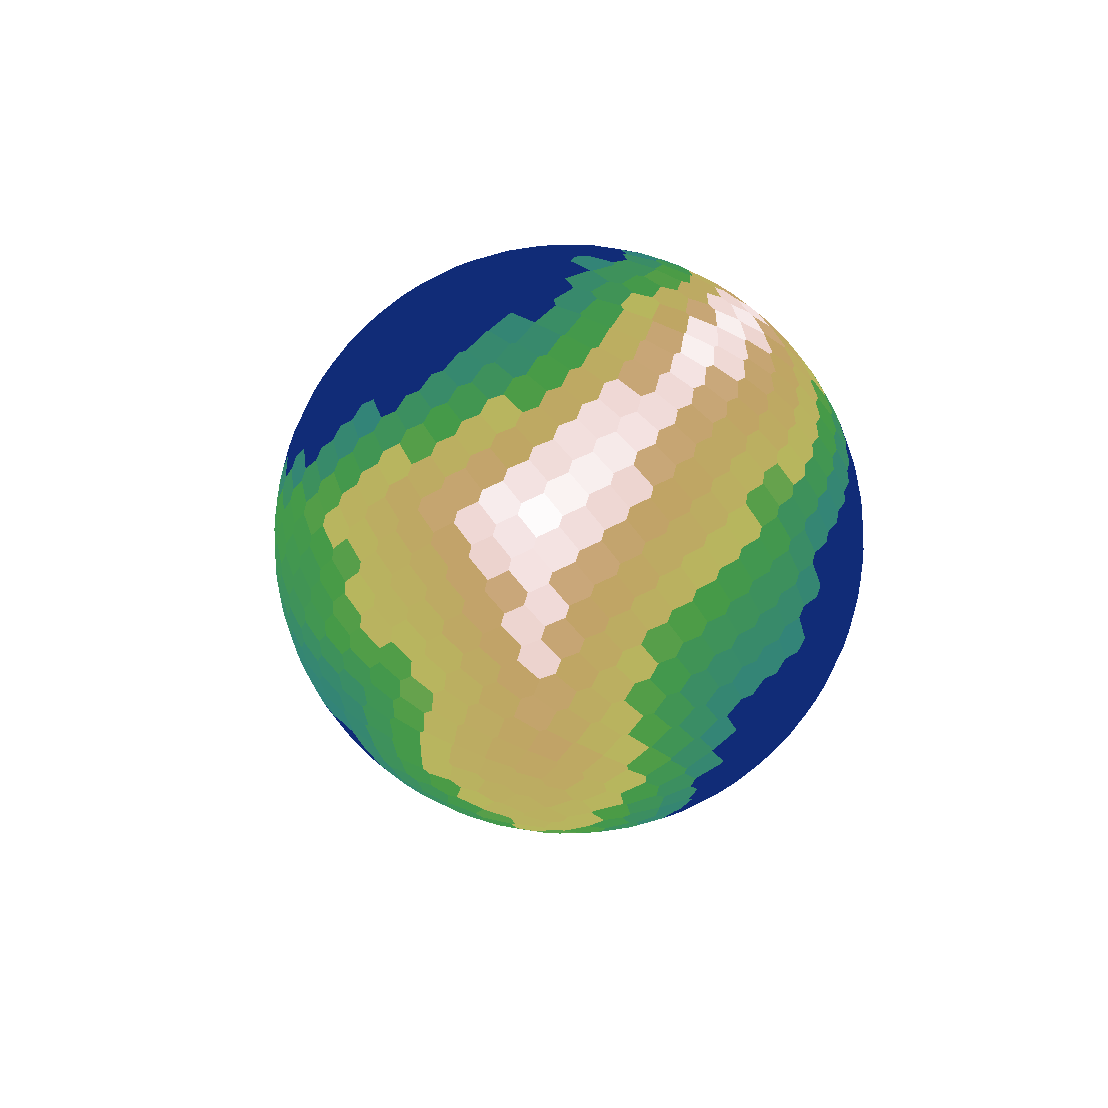

In [14]:
import mpl_toolkits.mplot3d as a3
facets_vor = np.load('facets_vor_n'+str(numpoints)+'.npy',allow_pickle=',')

snowheight = 0.8
soilheight = 0.4
waterheight = 0
albedo_map_r = np.zeros(numpoints)
for i in range(numpoints):
    if alts[i] >= snowheight*max_alt:#snow
        albedo_map_r[i] = 0.6+(alts[i]-snowheight*max_alt)/(max_alt-snowheight*max_alt)*0.3
    elif alts[i] < 0.0: #water
        albedo_map_r[i] = 0.06
    elif (alts[i] >= soilheight*max_alt and alts[i]<snowheight*max_alt): #soil
        albedo_map_r[i] = 0.3+(alts[i]-soilheight*max_alt)/(snowheight*max_alt-soilheight*max_alt)*0.2
    elif (alts[i] >= waterheight*max_alt and alts[i]<soilheight*max_alt): #forest
        albedo_map_r[i] = 0.1+(alts[i]-waterheight*max_alt)/(soilheight*max_alt-waterheight*max_alt)*0.2 
        
gist_earth = mpl.cm.get_cmap('gist_earth',4000) #colors
N = 256
y1 = gist_earth(np.linspace(0.02,0.15,int(N*0.1))) #ocean colors
y2 = gist_earth(np.linspace(0.3,0.5,int(N*0.2))) #forest colors
y3 = gist_earth(np.linspace(0.7,0.85,int(N*0.25))) #soil colors
y4 = gist_earth(np.linspace(0.93,1,int(N*.35))) #snow colors
y = np.vstack((y1,y2,y3,y4))

cmap_albedo = LinearSegmentedColormap.from_list('custom earth', y, N=256)

fig = plt.figure(figsize = [20,20])
ax = fig.add_subplot(111,projection='3d')
norm = mpl.colors.Normalize(vmin=0,vmax=0.9)
cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = cmap_albedo)
cmapplot.set_array([])
# cb = fig.colorbar(cmapplot, ax=ax, orientation='horizontal',shrink=1/1.5, aspect=40,pad=-0.6)
# cb.set_label('Albedo')
# plot the facets

ax.add_collection3d(a3.art3d.Poly3DCollection(facets_vor,facecolor= cmap_albedo(albedo_map_r/0.9),antialiased=False))

ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
ax.axis('off')
ax.elev = 180 #elev=0, azim=270 for edge-on. elev=90, azim=270 for face-on from above.
ax.azim = 0
filename = 'albedos/3dnocb_albedo_range_seed'+ str(seed_no) +'n' + str(numpoints) + '.png'
os.makedirs(os.path.dirname(filename), exist_ok=True)
fig.savefig(filename,dpi=100,bbox_inches='tight')
plt.show()